In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "./input"]).decode("utf8"))


category_names.csv
train_example.bson



The bson files for this competition contain a list of dictionaries, one dictionary per product. Each dictionary contains a product id (key: _id), the category id of the product (key: category_id), and between 1-4 images, stored in a list (key: imgs). Each image list contains a single dictionary per image, which uses the format: {'picture': b'...binary string...'}. 

The bson file can be read and processed iteratively. The following code shows how to read the data from the `train_example.bson` file.

In [2]:
import io
import bson                       # this is installed with the pymongo package
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.data import imread   # or, whatever image library you prefer
import multiprocessing as mp      # will come in handy due to the size of the data

In [3]:
import matplotlib.gridspec as gridspec

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images): #show batch images
    fig = plt.figure(figsize=(20, images.shape[0]))
    gs = gridspec.GridSpec(images.shape[0]//5 + 1, 5)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img)
    return 

In [4]:
# Simple data processing

data = bson.decode_file_iter(open('./input/train_example.bson', 'rb')) #iterator for the test file

prod_to_category = dict()
images = []

for c, d in enumerate(data):
    product_id = d['_id']
    category_id = d['category_id'] # This won't be in Test data
    prod_to_category[product_id] = category_id
    for e, pic in enumerate(d['imgs']):
        picture = imread(io.BytesIO(pic['picture']))
        images.append(picture)

prod_to_category = pd.DataFrame.from_dict(prod_to_category, orient='index')
prod_to_category.index.name = '_id'
prod_to_category.rename(columns={0: 'category_id'}, inplace=True)

In [5]:
prod_to_category.head()

category_id
_id             
0     1000010653
1     1000010653
2     1000004079
3     1000004141
4     1000015539

# **Take a look at least 100 samples**

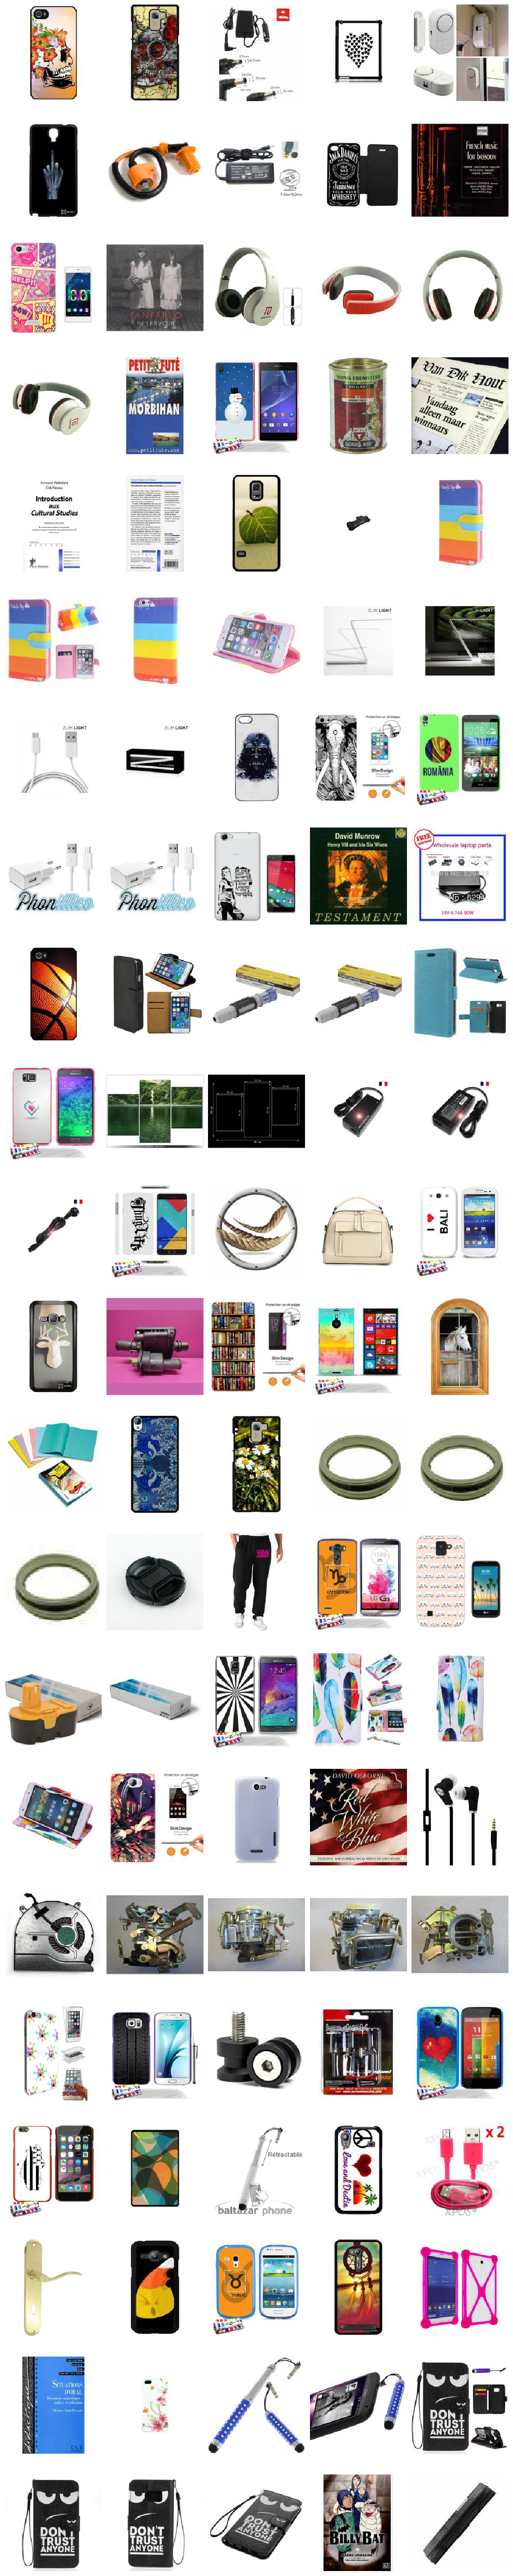

In [6]:
images = np.stack(images, axis=0)
show_images(images)

# conclustion
Quite imbalanced dataset, e.g., lots of smartphone cases. Might not be true in the real train dataset.

For more efficient use of your resources, you can use the `multiprocessing` module to read and process the bson file.

Inspiration for this code is from:  https://stackoverflow.com/questions/43078980/python-multiprocessing-with-generator Note this may be slower on a small file, due to the overhead setting up the workers, but will be significantly faster for the large files.

In [7]:
NCORE =  4

prod_to_category = mp.Manager().dict() # note the difference
images = mp.Manager().list()

def process(q, iolock):
    while True:
        d = q.get()
        if d is None:
            break
        product_id = d['_id']
        category_id = d['category_id']
        prod_to_category[product_id] = category_id
        for e, pic in enumerate(d['imgs']):
            picture = imread(io.BytesIO(pic['picture']))
            images.append(picture)
    
q = mp.Queue(maxsize=NCORE*2)
iolock = mp.Lock()
pool = mp.Pool(NCORE, initializer=process, initargs=(q, iolock)) #start the workers.

# process the file

data = bson.decode_file_iter(open('./input/train_example.bson', 'rb'))
for c, d in enumerate(data):
    q.put(d)  # blocks until q below its max size

# tell workers we're done

for _ in range(NCORE):  
    q.put(None)
pool.close()
pool.join()

# convert back to normal dictionary
prod_to_category = dict(prod_to_category)

prod_to_category = pd.DataFrame.from_dict(prod_to_category, orient='index')
prod_to_category.index.name = '_id'
prod_to_category.rename(columns={0: 'category_id'}, inplace=True)

In [8]:
prod_to_category.head()

category_id
_id             
0     1000010653
2     1000004079
1     1000010653
3     1000004141
4     1000015539

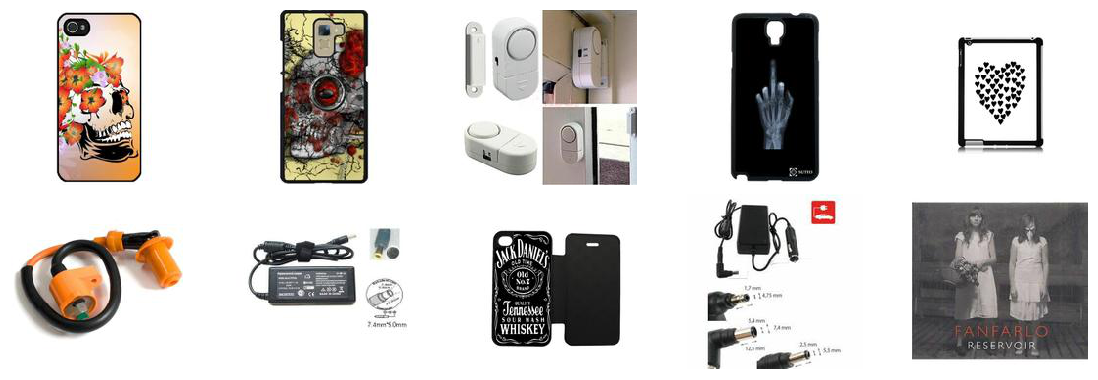

In [9]:
images = np.stack(images, axis=0)
show_images(images[:10])